## Introduction

This is an extremely niche topic, especially in the context or Arma 3. I'll do my best to make it understandable with little prior knowledge about the topic. After a brief overview on the subject, this notebook concentrates on the actions performed on the extracted data using Python and SQL via Python's sqlite3 library. It doesn't explain the data extraction itself in full detail. (from Arma 3 to the `.sqf`-files in `Python/src/fired shots sqf`-folder).


#### Technical aspects covered in this notebook
* Modifying ndarray-shaped data created in another program (Arma 3 /`.sqf`) using Python
* Importing data from a text file to a local SQL database using Python (`sqlite3` library)
  * In SQL: Basic data definition, manipulation and queries
  * i.e. Table creation, inserting to, altering & updating tables, deleting, queries
* Cleaning data using Python (in this case by removing a cluster using `sklearn.cluster.Kmeans`)
* Visualizing data using `matplotlib.pyplot` (`pandas.plot`)
* Pandas DataFrames (as the data structure used in Python)

### Topic & Motivation
Arma 3 is a sandbox military simulation / shooter game with immense modding support which means the players may program the game to their liking in about every aspect. This modability is also how I extracted the data in Arma 3 using `fn_calculate_bullet_offset.sqf`. </br>

The [Advanced_ballistics module of ACE3 modification](https://github.com/acemod/ACE3/tree/master/addons/advanced_ballistics) is an example of what modded Arma 3 has to offer. Using it gave me an idea of basically storing the impacts of shots in Arma 3, and then visualizing them in Python. I'll explain the data in further detail later during the steps.

As it became apparent there's no point in pasting `.sqf` arrays with tens of thousands of characters to a Python file, I decided to add **an extra challenge to this project by storing the data from text files to a SQL database**, albeit a local one at that :). I had taken the basic course about SQL but it consentrated on queries and ER diagrams, and was strictly limited to a SQL environment without covering *the actual use* of those databases. Hence, I wanted to experiment interacting with a SQL database using another programming language while keeping the `.py` files clean of the data from Arma 3.



## Preparations

### Imports & Global Vars

First, we need to import libraries & functions from the project folder for data processing and visualization. </br>
Global variables are also defined. `DB_PATH` and `TABLE_NAME` will be used through the code!

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew, skewtest, kurtosistest
# from sklearn.cluster import KMeans  # KMeans may be used later. There's a separate import for it

import sqlite3

from sqlite3_funcs import sqlite_to_df, initialize_db_n_table, insert_into_DB, delete_from_table, standardize_column
from data_processing_funcs import different_bin_counts

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams["figure.dpi"]=80

DB_PATH = "fired_shots.db"
print("DB path:  ", DB_PATH)
TABLE_NAME = "shots"


Base dir:  c:\Users\Ari\OneDrive - TUNI.fi\Tiedostot\Arma 3 - Other Profiles\A%2e%20Pike\missions\360 Sniper\ACE3-AB-Zeroer.VR\Python\src
DB path:   fired_shots.db


### Initialization of the database

The database & table in it are initialized next. The table is created with the following query where `TABLE_NAME = shots`. </br>
</br>
Note SQLite is used & some of the definitions get simplified based on the chart [here at 3.1.1. Affinity Name Examples](https://www.sqlite.org/datatype3.html). It doesn't affect the functionality of the code.
```sql
CREATE TABLE shots (
    id INT PRIMARY_KEY,             -- A unique ID per a shot
    x DECIMAL(7,6),                 -- The x-error, from the direction the gun was facing. Initially not 0.
    y DECIMAL(7,6),                 -- The y-error, from the direction the gun was facing. Initially not 0.
    dist_from_mean DECIMAL(8,7),    -- distance from [x,y] to [mean_x, mean_y]
    firing_range INT,               -- Distance from the shooter to the target, meters
    weapon VARCHAR(10),             -- Arma 3 classname of the weapon used for the shot
    weap_short VARCHAR(6),          -- A shorter name for weapon.
    ammo_type VARCHAR(6),           -- Arma 3 classname of the ammo used for the shot
    data_batch INT                  -- For identifying which file the shot is from
)
```

Inspect the classifying columns of the database </br>

In [2]:
# If the project is run for the first time, initialize the database!

initialize_stuff = True

try:
    initialize_db_n_table(drop_if_exists=initialize_stuff, table_name=TABLE_NAME, database_path=DB_PATH)
    print("Database initialized successfully")
except sqlite3.OperationalError:
    print(f'The database with a table "{TABLE_NAME}" exists already & you decided to not drop the table!')

database_path in initilaize_db fired_shots.db
Table "shots" in "fired_shots.db" has currently 2022 rows
Table "shots" in "fired_shots.db" has currently 3968 rows
Table "shots" in "fired_shots.db" has currently 17985 rows
Table "shots" in "fired_shots.db" has currently 20000 rows
Database initialized successfully


### Add extra data batches

The following batches that aren't included in `initialize_db_n_table`. I recommend these are also added, though. The last addition, in particular adds more M110 values

In [3]:
# Once the database & sheet have been initialized, 
# you can also insert data without separate initialization

if initialize_stuff:  # manually comment out
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    print("The latest data batch:", data_batch_num)
    insert_into_DB("fired shots sqf/axmc_ball_600_raw.sqf",     TABLE_NAME, 600, "SPS_AI_AXMC338_27_PB_F", "axmc", "B_SPS_338_300gr_Berger_OTM", data_batch_num, DB_PATH)

if initialize_stuff:
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    print("The latest data batch:", data_batch_num)
    insert_into_DB("fired shots sqf/svdm_ball_600_raw.sqf", TABLE_NAME, 600, "rhs_weap_svdp_npz", "svdm", "rhs_B_762x54_7N1_Ball", data_batch_num, DB_PATH)

if initialize_stuff:
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    print("The latest data batch:", data_batch_num)
    insert_into_DB("fired shots sqf/sr1614_5_ball_600_raw.sqf", TABLE_NAME, 600, "Tier1_SR16_Carbine_Mod2_MFT_FDE", "sr16", "rhs_ammo_556x45_Mk262_Ball", data_batch_num, DB_PATH)

if initialize_stuff:
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    print("The latest data batch:", data_batch_num)
    insert_into_DB("fired shots sqf/m110_ball_1100_raw2.sqf", TABLE_NAME, 1100, "Tier1_M110k5_ACS_65mm", "m110", "Tier1_65CM_Ball", data_batch_num, DB_PATH)
    
initialize_stuff = False

The latest data batch: 4
Table "shots" in "fired_shots.db" has currently 21000 rows
The latest data batch: 5
Table "shots" in "fired_shots.db" has currently 23045 rows
The latest data batch: 6
Table "shots" in "fired_shots.db" has currently 25067 rows
The latest data batch: 7
Table "shots" in "fired_shots.db" has currently 27040 rows


## Data Exploration

### Overview to the data

The unit of measurement in this data is milliradians/MRADs. The x and y columns are the error of an impact from the position the gun was aiming at the time the shot was fired in Arma 3 in their respective axes. Without going too technical, it is important to notethe position where the gun is aiming and the mean point of impacts can be a different value

E.g. if there were only two impacts `imps=[[0.25,0.3],[-0.15,0.1]]]`
* The direction the gun faces is origin `[0,0]`
* The first impact deviated 0.25 MRADs to the right AND 0.3 MRADs up from the direction the gun was facing.
* The mean point of impacts is `[avg(0.25,-0.15), avg(0.3,0,1)] = [0.05,0.2]` --> The mean point of impacts deviated 0.05 MRADs to right and 0.2 MRADs up

### Initial query

A broad SELECT query is conducted to get an overview of the data we're working with. The data in `{TABLE_NAME} (shots)` is grouped by their batch.

In [4]:
q = '''
SELECT weapon, weap_short, firing_range, data_batch, COUNT(id) as count, AVG(dist_from_mean) as avg_impact_distance_from_mean, AVG(x) as x_mean, AVG(y) as y_mean
FROM shots
GROUP BY data_batch
--ORDER BY avg_impact_distance_from_mean
'''

# Get an overview of the data
sqlite_to_df(q, DB_PATH)

,weapon,weap_short,firing_range,data_batch,count,avg_impact_distance_from_mean,x_mean,y_mean
0,Tier1_M110k5_ACS_65mm,m110,1100,0,2022,0.046114,0.272448,-0.373615
1,SPS_AI_AXMC338_27_DE_F,axmc,1100,1,1946,0.054874,-0.231472,0.125740
2,srifle_LRR_camo_F,m200,1100,2,14017,0.059883,0.231302,-0.136974
3,rhs_weap_XM2010,m2010,1100,3,2015,0.097753,-0.273567,0.486374
4,SPS_AI_AXMC338_27_PB_F,axmc,600,4,1000,0.070663,0.147117,0.064716
5,rhs_weap_svdp_npz,svdm,600,5,2045,0.416056,0.261440,0.005645
6,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,6,2022,0.243675,0.281618,0.266969
7,Tier1_M110k5_ACS_65mm,m110,1100,7,1973,0.045839,-0.225142,-0.468393


### Standardizing x- and y-axes

Currently the x and y columns of the table aren't standardized in the sense that mean(x) = 0.

SQL's `AVG()` is used to make the edit straight into the database, as the original offsets from the origin aren't relevant.

In [5]:
# You may comment this out after the initial execution, as the x and y columns are standardized after the first execution
# The mean will never be 0 due to the limited number of decimals in the x and y columns of the shots table
if True:
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    # from 0 to the last data_batch. The addition is required, as teh end of range is exclusive
    for data_batch in range(0,data_batches_df.max().iloc[0]+1):
        standardize_column("x", data_batch, TABLE_NAME, DB_PATH)
        standardize_column("y", data_batch, TABLE_NAME, DB_PATH)

Check the batches after the standardization. </br>
</br>
The means are now almost equal to zero. The remaining error is insignificant.

In [6]:
q = '''
SELECT weapon, weap_short, firing_range, data_batch, COUNT(id) as count, AVG(x) as x_mean, AVG(y) as y_mean
FROM shots
GROUP BY data_batch
'''

# Get an overview of the data
sqlite_to_df(q, DB_PATH)

,weapon,weap_short,firing_range,data_batch,count,x_mean,y_mean
0,Tier1_M110k5_ACS_65mm,m110,1100,0,2022,-1.850097e-16,2.761282e-16
1,SPS_AI_AXMC338_27_DE_F,axmc,1100,1,1946,-4.257471e-17,-1.663623e-16
2,srifle_LRR_camo_F,m200,1100,2,14017,6.515343e-16,5.996369e-16
3,rhs_weap_XM2010,m2010,1100,3,2015,-1.952946e-16,5.878948e-17
4,SPS_AI_AXMC338_27_PB_F,axmc,600,4,1000,-1.215694e-16,5.982020e-17
5,rhs_weap_svdp_npz,svdm,600,5,2045,2.330383e-16,7.021007e-17
6,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,6,2022,3.795458e-17,-2.054077e-16
7,Tier1_M110k5_ACS_65mm,m110,1100,7,1973,9.542122e-17,-4.869113e-16


### Querying SQL to pd.DataFrames

Let's compare the precision of the four guns which have data from `firing_range` of 1100! </br>
</br>
Start by querying the tables from the database to Pandas DataFrames using sqlite3 & getting different bin counts for the histogram </br>
</br>
The shorter names work perfectly here to classify the guns based on their ballistic performance. </br>
E.g., each gun with `weap_short="axmc"` have the same ballistic properties! </br>
Only the Arma 3 class name (`weapon`) is slightly different. </br>
</br>
NB! In this case, grouping by `weap_short` combines the two different batches of m110!

In [7]:
# Create a query for the selected weapons

q = f"""
SELECT weap_short, COUNT(weap_short) as "Row count"
FROM {TABLE_NAME} 
WHERE firing_range=1100
GROUP BY weap_short
ORDER BY AVG(shots.dist_from_mean)
"""

iter_df = sqlite_to_df(q, DB_PATH)
iter_df

,weap_short,Row count
0,m110,3995
1,axmc,1946
2,m200,14017
3,m2010,2015


In [8]:
dfs = {}            # The actual dataframes based on the query
bin_cnts = {}       # Histogram bin counts per df

firing_range = 1100

for weap_short in iter_df["weap_short"].to_list():
    
    # Note the firing_range is sepcified here, too.
    
    # data_batch is selected for tracking potential issues
    q = f'''
    SELECT id, x, y, dist_from_mean, data_batch
    FROM shots
    WHERE (weap_short = "{weap_short}" AND firing_range = {firing_range})
    '''
    dfs[weap_short] = sqlite_to_df(q, DB_PATH)
    
    bin_cnts[weap_short] = different_bin_counts(dfs[weap_short]["dist_from_mean"].to_numpy())
    
    print(dfs[weap_short].shape)

(3995, 5)
(1946, 5)
(14017, 5)
(2015, 5)


### Visual exploration
Let's start the data inspection by having a general look at the distribution of the distances from mean for each shot with a histogram

Weapon:   m110    column: x    Kurtosis: -0.129   Skewness: -0.024 
SkewtestResult(statistic=-0.6188393490470718, pvalue=0.5360221971250588) 
KurtosistestResult(statistic=-1.7282222953731572, pvalue=0.08394837799649285) 

Weapon:   axmc    column: x    Kurtosis: +0.323   Skewness: +0.341 
SkewtestResult(statistic=5.992800851339827, pvalue=2.0625737733776773e-09) 
KurtosistestResult(statistic=2.613404464740004, pvalue=0.008964514244410176) 

Weapon:   m200    column: x    Kurtosis: -0.267   Skewness: -0.012 
SkewtestResult(statistic=-0.5623730403905267, pvalue=0.5738618833779755) 
KurtosistestResult(statistic=-7.437357488896802, pvalue=1.0271930059285903e-13) 

Weapon:  m2010    column: x    Kurtosis: -0.420   Skewness: -0.052 
SkewtestResult(statistic=-0.9549624822668936, pvalue=0.3395966701664912) 
KurtosistestResult(statistic=-4.8536240668291715, pvalue=1.2122544149469867e-06) 



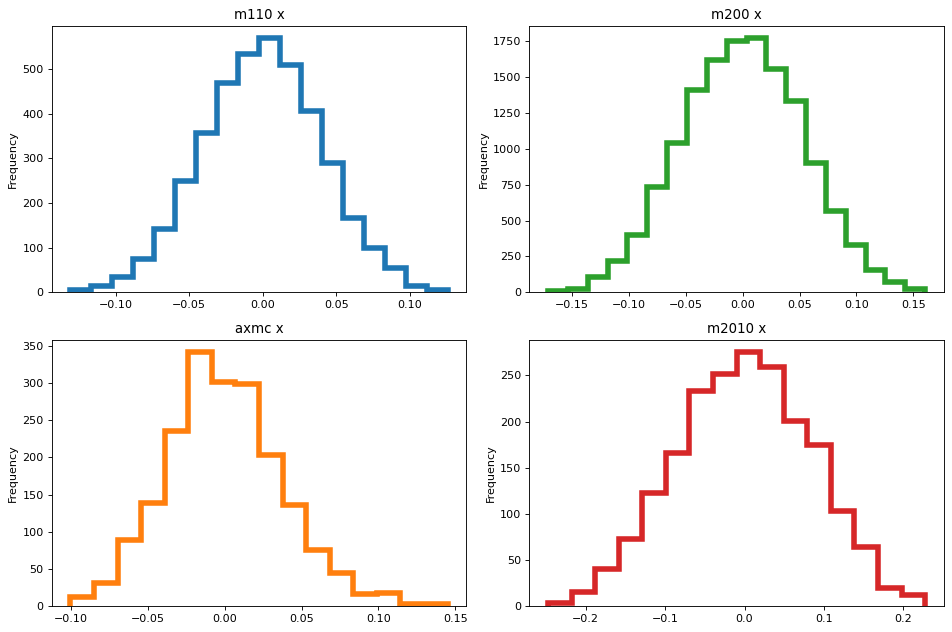

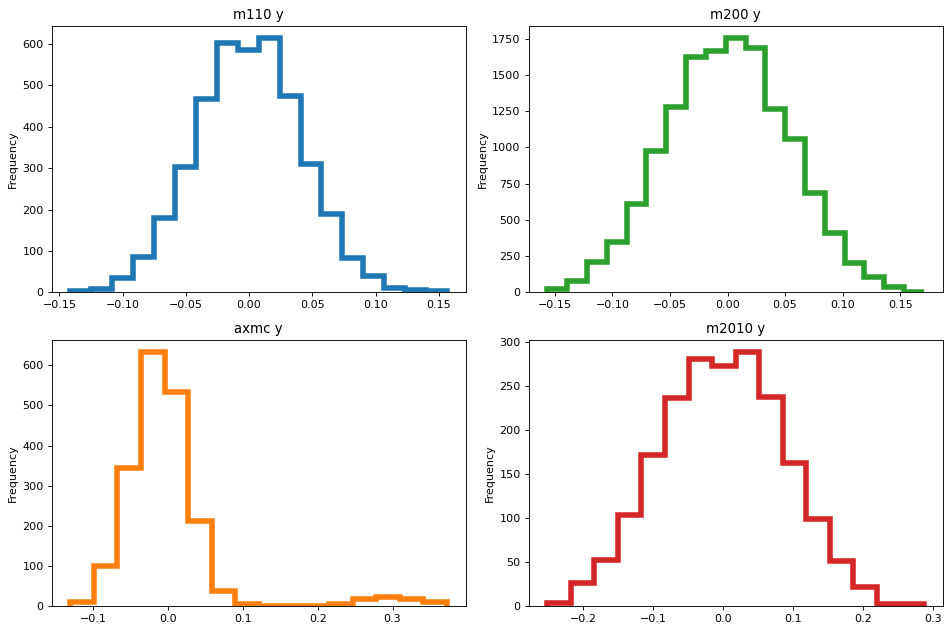

In [9]:

figx, axsx = plt.subplots(tight_layout=True, nrows=2, ncols=2)
figy, axsy = plt.subplots(tight_layout=True, nrows=2, ncols=2)

for i, weap_short in enumerate(dfs):
    dfs[weap_short]["x"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=axsx[i%2, int(i == 2 or i == 3)],
        title=f"{weap_short} x")
    
    dfs[weap_short]["y"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=axsy[i%2, int(i == 2 or i == 3)],
        title=f"{weap_short} y")
    
    print(f"Weapon: {weap_short:>6}    column: x    Kurtosis: {kurtosis(dfs[weap_short]['x']):>+2.3f}   Skewness: {skew(dfs[weap_short]['x']):>+2.3f} \n{skewtest(dfs[weap_short]['x'])} \n{kurtosistest(dfs[weap_short]['x'])} \n")
    

   m110 0.023548153462080012
   axmc 0.05580807404522491
   m200 0.030112900348527004
  m2010 0.048033962120689715


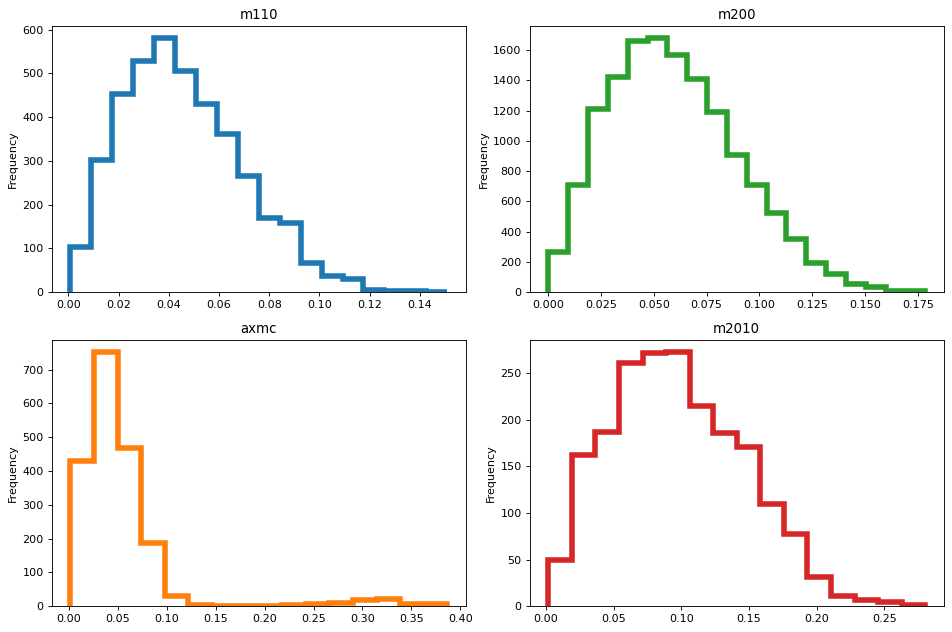

In [10]:
fig, axs = plt.subplots(tight_layout=True, nrows=2, ncols=2)

for i, weap_short in enumerate(dfs):
    dfs[weap_short]["dist_from_mean"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=axs[i%2, int(i == 2 or i == 3)],
        title=weap_short)
    
    print(f"{weap_short:>7} {np.std(dfs[weap_short]['dist_from_mean'])}")

M110 seems to be the most accurate so far but AXMC data has some significant outliers! </br>
</br>
Let's investigate it further by taking a separate scatter plot of AXMC to get a better understanding of the situation!.

<AxesSubplot:xlabel='x', ylabel='y'>

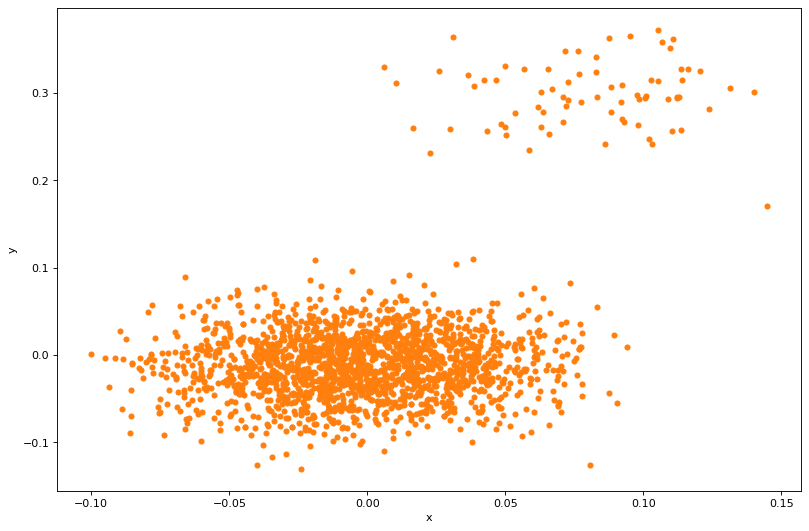

In [11]:
dfs["axmc"].plot.scatter("x", "y", c="C1")

## Data Cleaning

### Overview
There are dozens of data points some 0.3 MRADs higher and slightly to the right from the mean. </br>
As both the horizontal and vertical dispersion of the bullets should be normally distributed, the issue is probably in the shot being fired before the barrel was pointing at the target.</br>
</br>
The faulty values will be cleaned. In this case, they aren't needed in the database, either!
</br>
</br>

This time no fancy statistical/ML methods are required.</br>
Instead we only really need to get the y-value of the rightmost impact and delete all impacts whose y-value is equal to or higher than its.</br>
</br>
A KMeans clustering can be implemented for the sake of an example & a more general case

In [12]:
# Choose
clustering = True                           # Clustering method vs. manually taking the values higher than the rightmost impact
delete_errorous_rows_from_table = False     # Delete the errorous values from the DB or not

#### Option 1: Clustering

The more general solution to the problem. Works even if the rightmost value wasn't the value with the lowest y-value of the coordinates we want gone

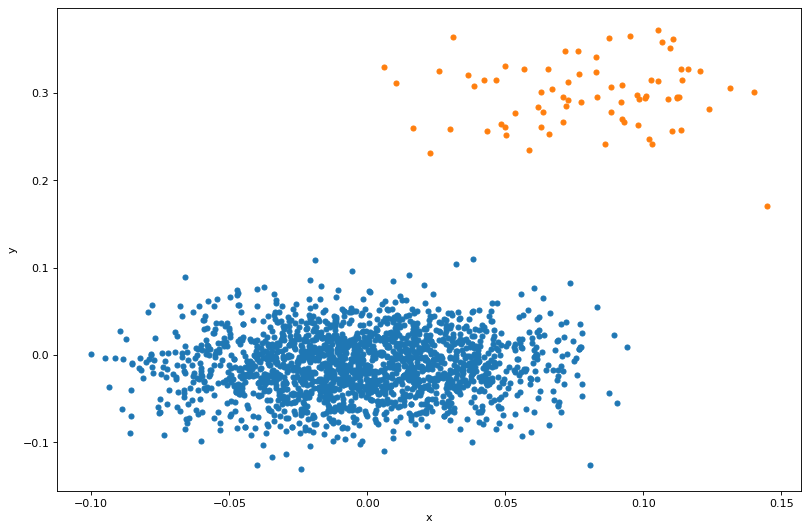

In [13]:
if clustering:
    from sklearn.cluster import KMeans
    
    # There are two distinguishable clusters
    km = KMeans(n_clusters=2)

    pred = km.fit_predict(dfs["axmc"][["x","y"]])

    # Create a separate df to avoid dataframes in dfs-dict to have different column count
    df_axmc = dfs["axmc"][["id","x","y","data_batch"]]
    df_axmc["clusters"] = pred

    # C stands for both color and cluster here
    df_axmc_c0 = df_axmc[df_axmc.clusters==0]
    df_axmc_c1 = df_axmc[df_axmc.clusters==1]

    # Plot the clusters
    only_ax = df_axmc_c0.plot.scatter("x", "y", c="C0")
    df_axmc_c1.plot.scatter("x", "y", c="C1", ax=only_ax)
    
    # Tuple is used, as tuple's syntax is similar to SQL's WHERE IN syntax
    # e.g. WHERE column_name IN (value1, value2, ...); 
    errorous_cluster_ids = tuple(df_axmc_c1["id"].to_numpy())
    
    # Del_condition for delete_from_table would be
    del_condition = f"(id IN {errorous_cluster_ids})"
    

#### Option 2: Greater y than rightmost point

Based on the visualization, we can easily

In [14]:
if not clustering:

    max_y_row_i = dfs["axmc"]["x"].idxmax()
    max_y_row = dfs["axmc"].iloc[max_y_row_i]
    y_val = max_y_row["y"]
    faulty_data_batch = max_y_row["data_batch"]

    # With this information, as the TALBE_NAME (default "shots") of the database has already been standardized, 
    # we can delete all rows from the table with an y-value higher or equal to 0.170106 with the same data batch as 
    del_condition = f"(data_batch = {faulty_data_batch} AND y >= {y_val})"


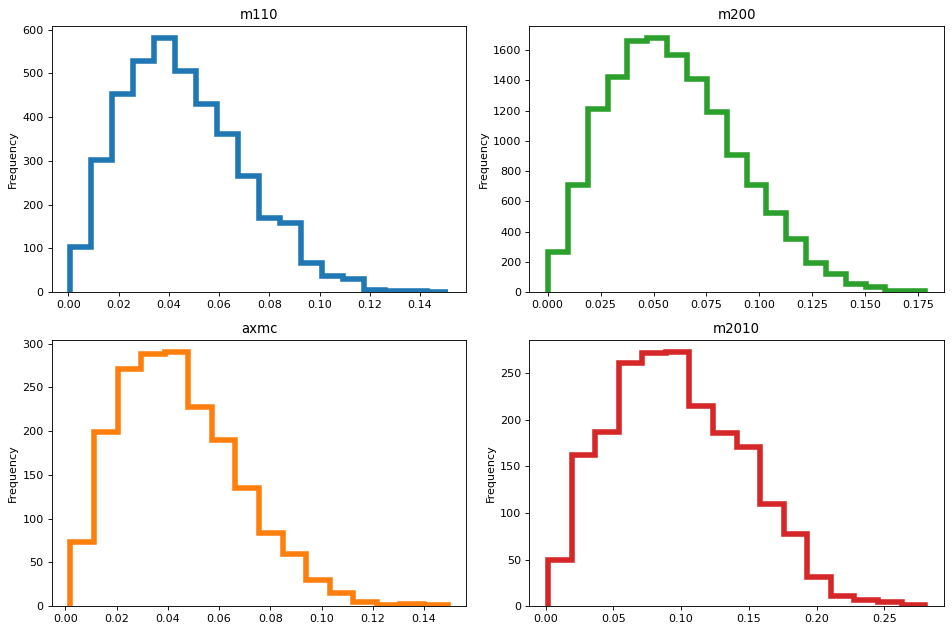

In [15]:
# After the deletion of the faulty rows, update dfs["axmc"]
q = f'''
    SELECT x, y, dist_from_mean
    FROM shots
    WHERE (weap_short = "axmc" AND firing_range = 1100 AND NOT {del_condition})
    '''
dfs["axmc"] = sqlite_to_df(q, DB_PATH)

# Now, let's see if the histogram looks better
fig, axs = plt.subplots(tight_layout=True, nrows=2, ncols=2)

for i, weap_short in enumerate(dfs):
    dfs[weap_short]["dist_from_mean"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=axs[i%2, int(i == 2 or i == 3)],
        title=weap_short)

## Final Visualizations

In [55]:
# Selects the length of the shortest dataframe in dfs dict
n = min([val.shape[0] for val in dfs.values()])
print("Minimum count of shots per df:", n)
seed = 1 # Seed for random_state of pd.DataFrame.sample

sample_dfs = {}
sample_dfs_bin_counts = {}

for weap_short in dfs:
    sample_dfs[weap_short] = dfs[weap_short].sample(n, random_state=seed)
    sample_dfs_bin_counts[weap_short] = different_bin_counts(sample_dfs[weap_short]["dist_from_mean"])


Minimum count of shots per df: 1872


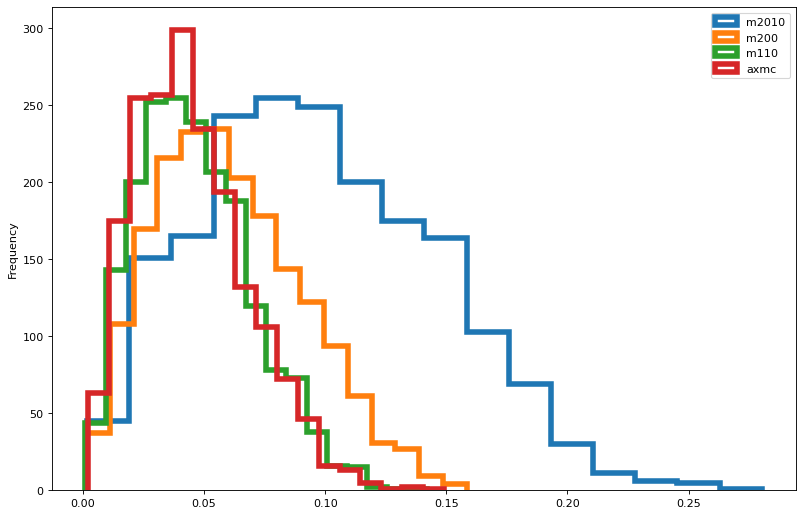

In [56]:
# Re-sort the DataFrame based on the standard deviation of the distance_from_mean
# The ordered are 
sample_dfs_sorted = dict(sorted(sample_dfs.items(), reverse=True, key=lambda item: np.std(item[1]["dist_from_mean"])))

# i -> index, weap_short -> key
for i, weap_short in enumerate(sample_dfs_sorted):
    
    if i == 0:
        only_ax = sample_dfs[weap_short]["dist_from_mean"].plot.hist(
            bins=sample_dfs_bin_counts[weap_short]["doane"],
            histtype="step",
            linewidth=5,
            color=f"C{i}")
    else:
        sample_dfs[weap_short]["dist_from_mean"].plot.hist(
            bins=sample_dfs_bin_counts[weap_short]["doane"],
            histtype="step",
            linewidth=5,
            color=f"C{i}",
            ax=only_ax)

only_ax.legend(list(sample_dfs_sorted))

plt.show()

m2010  i= 0.7853981633974483  coords:  [0.21213203435596426, 0.21213203435596426]
m200  i= 2.356194490192345  coords:  [-0.21213203435596423, 0.21213203435596426]
m110  i= 3.9269908169872414  coords:  [-0.2121320343559643, -0.21213203435596423]
axmc  i= 5.497787143782138  coords:  [0.2121320343559642, -0.2121320343559643]


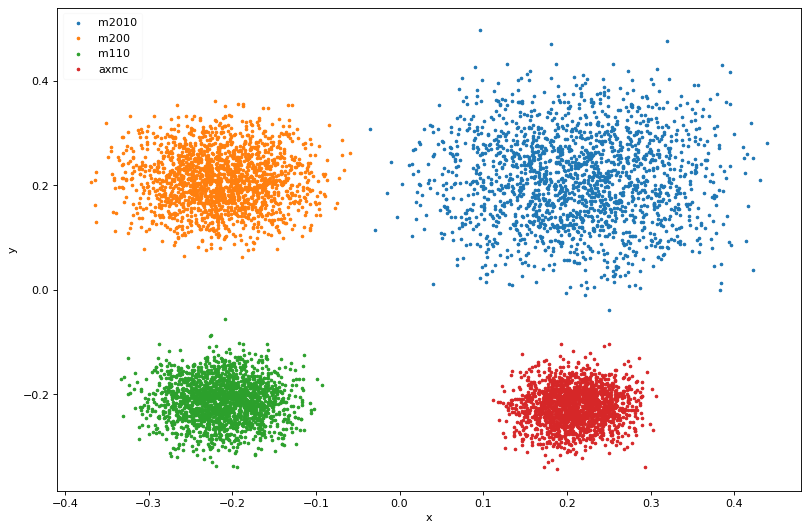

In [58]:
# View the same data on a scatter plot

# I was thinking about the most elegant implementation & 
# decided to use polar coordinates to distribute the 
# scatter plots evenly around the origin on one axis
# here x = r*cos(theta) & y = r*sin(theta)

dist_from_origin = 0.3

# Yeah, this is a bit convoluted approach, but the point is to
for i, weap_short in enumerate(sample_dfs_sorted):
    
    # To get even split in quartals
    #       45 degs + i*90 degs in radians
    angle = 0.25*np.pi + i*0.5*np.pi
    mean_pos_x = dist_from_origin*np.cos(angle) 
    mean_pos_y = dist_from_origin*np.sin(angle)
    print(weap_short, " i=", angle, " coords: ", [mean_pos_x, mean_pos_y])
    
    _df = pd.concat(objs=(sample_dfs[weap_short]["x"] + mean_pos_x, sample_dfs[weap_short]["y"] + mean_pos_y), axis=1)
    
    if i == 0:
        only_ax = _df.plot.scatter(
            "x", "y",
            s=5,
            color=f"C{i}")
    else:
        _df.plot.scatter(
            "x", "y",
            s=5,
            color=f"C{i}",
            ax=only_ax)

only_ax.legend(list(sample_dfs_sorted), loc="best", framealpha=0.11)

plt.show()

AXMC (orange) appears to have higher standard deviation than M110 or M200 even though its impacts seems to be on a slammer area.</br>
SDs don't lie but let's try a heatmap implementation inspired by [this stackoverflow post.](https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set)</br>
